## Preparing simulation system

In [4]:
#Libraries and main variables initialized
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd
import numpy as np
import urllib.request, json
import os
import re
import nglview as nv
from funcs import get_files_from_git
from funcs import view_nucl
from IPython.display import Markdown, display

#Reloading funcs if changed
from importlib import reload 
import funcs,config
reload(funcs)
reload(config)

%matplotlib inline

from IPython.display import Markdown, display
from config import folder,descr,pname,ssh_host
display(Markdown(descr))
print("Folder set to: ",folder)
print("Project name: ",pname)
print("SSH host set to:",ssh_host)




# MD simulations of H3-H4 with 30 bp of DNA, tails truncated
- AMBER14SB force field
- 50 mM NaCl
- box 2nm


Folder set to:  h3-h4_tm_DNA
Project name:  h3-h4_tm_DNA
SSH host set to: lomo2g


### Donwload and prepare pdb
- We use 1kx5 as in JMB paper https://www.ncbi.nlm.nih.gov/pubmed/26699921
- We use maximim tuncation up to the essential elements (helixes, key arginines, docking domain). But also try not to create unbalanced charges (see figure below).
- The h3-h4_maximally tuncated is H3 residues 43-end(135), H4 residues 23-end(102) (see figure below).
- Due to AMBER ff, we add ACE residues on truncated N-termi using MDanalysis

<img src="cutting.jpg">

In [21]:
%%bash --out output --err error
wget https://files.rcsb.org/view/1KX5.pdb

In [55]:
nucl=mda.Universe("1KX5.pdb")
#For AMBER FF to place ACE on N-truncated end we need to retain one more residue
# CHARMM can handle it differently directly in pdb2gmx

idsI=' '.join(map(str,range(-29,0)))
idsJ=' '.join(map(str,range(2,31)))
print(idsI,idsJ)
sel_text="(segid I and (resnum %s or (resnum -30 and not (name P OP1 OP2)))) or (segid J and (resnum %s or (resnum 1 and not (name P OP1 OP2)))) or (segid A and (resid 44:135 or (resid 43 and name C O CA))) or (segid B and (resid 23:102 or (resid 22 and name C O CA)))"%(idsI,idsJ)
#and we take first solvation shell
#This line should go before atom renaming!!!
dimer=nucl.select_atoms(sel_text+" or (resname HOH and around 3 %s)"%sel_text)

nucl.select_atoms("segid A and resid 43").residues.resnames='ACE'
nucl.select_atoms("segid A and resid 43 and name CA").atoms.names='CH3'
nucl.select_atoms("segid B and resid 22").residues.resnames='ACE'
nucl.select_atoms("segid B and resid 22 and name CA").atoms.names='CH3'

#This is an example of adding NME terminus on C end
#dimer=nucl.select_atoms("(segid C and (resid 16:102 or (resid 15 and name C O CA) or (resid 103 and name N CA))) or (segid D and (resid 34:122 or (resid 33 and name C O CA)))")
#nucl.select_atoms("segid C and resid 103").residues.resnames='NME'
#nucl.select_atoms("segid C and resid 103 and name CA").atoms.names='CH3'

nucl.select_atoms("name OP1").atoms.names='O1P'
nucl.select_atoms("name OP2").atoms.names='O2P'


nucl.trajectory.remarks=[]
nucl.trajectory.compound=[]
nucl.trajectory.header=['H3-H4 dimer with 30 bp of DNA, histone tails maximally truncated']

#print(dimer.atoms.names)
dimer.write("h3-h4_tm_DNA.pdb")

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:72: UserWarning: Failed to guess the mass for the following atom types: MN
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


-29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30


In [56]:
#This will currently work only in Jupyter Notebook
nv.show_mdanalysis(dimer,gui=False)

NGLWidget()

### We need to specify force field and path to download it from git
- Here we use AMBER 14SB for Gromacs (Need to check)
- In this repo https://github.com/intbio/gromacs_ff/ we store all the forcefield that we check manually or adjust
- Folder for AMBER 14SB ff is amber14sb_parmbsc1.ff 
- Folder for AMBER 14SB ff with CUFIX is amber14sb_parmbsc1_cufix.ff   
- We need to specify a GitHub API URL for it below

In [33]:
#Set URL here
#Intentianally commented out to make an informed choice
#ff_name='amber14sb_parmbsc1'
#ff_name='amber14sb_parmbsc1_cufix'
ffurl="https://api.github.com/repos/intbio/gromacs_ff/contents/%s.ff"%ff_name
print("FF set to ",ff_name)

FF set to  amber14sb_parmbsc1_cufix


In [12]:
## Download protocols right away!

In [51]:
%%bash
rm -rf MDProtocols

In [52]:
#Set protocols URL
prot_url="https://api.github.com/repos/intbio/gmx_protocols/contents/amber"

In [53]:
get_files_from_git(prot_url,'MDProtocols/')

### Prepare directories, download forcefield

In [37]:
%%bash
#clean GMX_system
rm -rf GMX_system
mkdir -p GMX_system

In [38]:
get_files_from_git(ffurl,'GMX_system/%s.ff'%ff_name)

### Let's start with Gromacs commands

- manual for 2018 version is here http://manual.gromacs.org/documentation/current/manual-2018.3.pdf 
- Command line reference http://manual.gromacs.org/documentation/current/user-guide/cmdline.html


### PDB2GMX
- Prepare initial topology (.top), coordinates (.gro) and restrain files .
- http://manual.gromacs.org/documentation/current/onlinehelp/gmx-pdb2gmx.html

In [39]:
%%bash -s "$ff_name" --err err
# PDB2GMX
# Make an init gro file and topology
# Force filed AMBER99BSC1 !!!!!!!!!
# Water TIP3P
# Termini !IMPORTANT! on N-end we place  ACE termini on C-end we place charged group.
# NOTE: The AMBER force fields have unique forms for the terminal residues,
# and these are incompatible with the -ter mechanism.~
# You need to prefix your N- or C-terminal residue names with “N” or “C” respectively
# to use these forms, making sure you preserve the format of the coordinate file.
# Alternatively, use named terminating residues (e.g. ACE, NME).

#TODO we need to understnt ter in amber!!! and fix
cd GMX_system
gmx pdb2gmx -f ../h3-h4_tm_DNA.pdb -o init.pdb -p topol.top -i posre.itp -water tip3p -ff $1


Using the Amber14sb_parmbsc1_cufix force field in directory ./amber14sb_parmbsc1_cufix.ff

Reading ../h3-h4_tm_DNA.pdb...
Read 'MDANALYSIS FRAME 0: Created by PDBWriter', 2922 atoms
Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
Moved all the water blocks to the end
There are 4 chains and 8 blocks of water and 538 residues with 2922 atoms

  chain  #res #atoms
  1 'I'    30    611  
  2 'J'    30    613  
  3 'A'    93    753  
  4 'B'    81    641  
  5 ' '    69     69  (only water)
  6 ' '    68     68  (only water)
  7 ' '    96     96  (only water)
  8 ' '    62     62  (only water)
  9 ' '     3      3  (only water)
  10 ' '     2      2  (only water)
  11 ' '     2      2  (only water)
  12 ' '     2      2  (only water)

Reading residue database... (amber14sb_parmbsc1_cufix)
Processing chain 1 'I' (611 atoms, 30 residues)
Identified residue DC-30 as a starting terminus.
Identified residue DA-1 as a ending terminus.
Checking for duplicat

In [40]:
# Get total charge
for line in err.split('\n'):
    if 'Total charge in system' in line:
        charge=float(line.split()[-2])
print('Total charge is %.3f'%charge)

Total charge is -44.000


### Fixing posre.itp files
see this link for details
http://mdsquad.wikia.com/wiki/Change_position_restraint_force_constant_in_MDP

In [41]:
%%bash
cd GMX_system/
for i in posre_*; do
sed -i.bak 's/\(.*\)1000  1000  1000/\1 POSRES_FC POSRES_FC POSRES_FC/g' $i
#check if repaced
tail -n 1 $i
done
rm *.bak



   949     1   POSRES_FC POSRES_FC POSRES_FC
   952     1   POSRES_FC POSRES_FC POSRES_FC
  1546     1   POSRES_FC POSRES_FC POSRES_FC
  1321     1   POSRES_FC POSRES_FC POSRES_FC


### Solvating a molecule
- 2 nm to the border in a cubic box.
- http://manual.gromacs.org/documentation/current/onlinehelp/gmx-editconf.html
- http://manual.gromacs.org/documentation/current/onlinehelp/gmx-solvate.html

In [42]:
%%bash --err err
cd GMX_system
cp ../vdwradii.dat .
gmx editconf -bt octahedron -d 2 -c -f init.pdb -o init_box.pdb
gmx solvate -cp init_box.pdb -cs spc216.gro -o init_solv.pdb -p topol.top
# Sometime with DNA system the water gets inside DNA and the system then explodes
# That's why we use modified vdwradii file here.

Read 5682 atoms
Volume: 2101.66 nm^3, corresponds to roughly 945700 electrons
No velocities found
    system size :  6.029  8.458  4.556 (nm)
    diameter    :  9.112               (nm)
    center      :  6.828  9.960  1.295 (nm)
    box vectors : 10.595 18.117 10.949 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :2101.66               (nm^3)
    shift       : -0.272 -0.688  4.057 (nm)
new center      :  6.556  9.271  5.353 (nm)
new box vectors : 13.112 13.112 13.112 (nm)
new box angles  :  70.53 109.47  70.53 (degrees)
new box volume  :1735.24               (nm^3)

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may

### Determine the number of ions

- concentration is 150 mM NaCl
- we will calculate the number of waters and calculate the number of ions to add.

In [43]:
for line in err.split('\n'):
    if 'Number of solvent molecules:' in line:
        n_sol=int(line.split()[-1])
print('Amount of solvent molecules: %d'%n_sol)

#Set concentration in mol/liter
conc=0.150 
#Water 18 g/mol. in 1 liter 1000/18 mol
# for every 1000/18 water molecules we need conc of NaCl ion pairs.

n_ions=round(conc*(n_sol/(1000/18)))

if charge>=0:
    n_pos=int(n_ions)
    n_neg=int(n_ions+charge)
else:
    n_pos=int(n_ions-charge)
    n_neg=int(n_ions)
print('Amount of Na %d \nAmount of Cl %d'%(n_pos,n_neg))

Amount of solvent molecules: 54795
Amount of Na 192 
Amount of Cl 148


### Adding ions
- http://manual.gromacs.org/documentation/current/onlinehelp/gmx-grompp.html
- http://manual.gromacs.org/documentation/current/onlinehelp/gmx-genion.html

In [44]:
%%bash -s "$n_pos" "$n_neg"
cd GMX_system
gmx grompp -f ../MDProtocols/ions.mdp -c init_solv.pdb -p topol.top -o ions.tpr -maxwarn 1
gmx genion -s ions.tpr -o init_solv_ions.pdb -p topol.top -noneutral -pname NA -nname CL -np $1 -nn $2 <<!
SOL
!


++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot, H. Grubmueller, G. Groenhof
Quantifying Artifacts in Ewald Simulations of Inhomogeneous Systems with a Net
Charge
J. Chem. Theory Comput. 10 (2014) pp. 381-393
-------- -------- --- Thank You --- -------- --------

Analysing residue names:
There are:    60        DNA residues
There are:   174    Protein residues
There are: 55099      Water residues
Analysing Protein...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 112x112x112, spacing 0.117 0.117 0.117
This run will generate roughly 13 Mb of data
Will try to add 192 NA ions and 148 CL ions.
Select a continuous group of solvent molecules
Selected 14: 'SOL'

Processing topology
Replacing 340 solute molecules in topology file (topol.top)  by 192 NA and 148 CL ions.


                      :-) GROMACS - gmx grompp, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS de

### Making index file

http://manual.gromacs.org/documentation/2018/onlinehelp/gmx-make_ndx.html

We also need index that will have a group for non water and ions components

In [45]:
%%bash
#The group need to be adjusted!!!
cd GMX_system
gmx make_ndx -f init_solv_ions.pdb -o index.ndx <<!
!"Water_and_ions"
q
!

Going to read 0 old index file(s)
Analysing residue names:
There are:    60        DNA residues
There are:   174    Protein residues
There are: 54759      Water residues
There are:   340        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

  0 System              : 169387 atoms
  1 DNA                 :  1903 atoms
  2 NA                  :   192 atoms
  3 CL                  :   148 atoms
  4 Protein             :  2867 atoms
  5 Protein-H           :  1394 atoms
  6 C-alpha             :   172 atoms
  7 Backbone            :   518 atoms
  8 MainChain           :   694 atoms
  9 MainChain+Cb        :   855 atoms
 10 MainChain+H         :   863 atoms
 11 SideChain           :  2004 atoms
 12 SideChain-H         :   700 atoms
 13 Prot-Masses         :  2867 atoms
 14 non-Protein         : 166520 atoms
 15 Water              

                     :-) GROMACS - gmx make_ndx, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS d

## Making X-ray initial protein file to serve as a reference during analysis

A problem is that gromacs looses info about chain names - which is not good at all and will complicate downstream analysis. So we need to retain it.
init.pdb - still has the correct chain IDs, and since water and ions are added below it can serve for downstream analysis as reference structure.

In [46]:
%%bash 

#--out out
#gmx trjconv -f GMX_system/init_solv.pdb -s GMX_system/ions.tpr -o GMX_system/prot_ref.pdb << !
#1
#!

#Alternative
#gmx editconf -label R E -f GMX_system/init_solv_ions.pdb -n GMX_system/index.ndx -o GMX_system/prot_ref.pdb << !
#1
#!



In [47]:
%%bash
##We CANNOT use int_solv_ions - since the chains are renumbered!!!

gmx make_ndx -f GMX_system/init_box.pdb -o GMX_system/index_ref.ndx <<!
q
!
gmx editconf -f GMX_system/init_box.pdb -n GMX_system/index_ref.ndx -o GMX_system/sys_ref.pdb << !
non-Water
!
gmx editconf -f GMX_system/init_box.pdb -n GMX_system/index_ref.ndx -o GMX_system/prot_bb_ref.pdb << !
Backbone
!
gmx editconf -f GMX_system/init_box.pdb -n GMX_system/index_ref.ndx -o GMX_system/prot_bb-h_ref.pdb << !
MainChain+H
!






Going to read 0 old index file(s)
Analysing residue names:
There are:    60        DNA residues
There are:   174    Protein residues
There are:   304      Water residues
Analysing Protein...

  0 System              :  5682 atoms
  1 DNA                 :  1903 atoms
  2 Protein             :  2867 atoms
  3 Protein-H           :  1394 atoms
  4 C-alpha             :   172 atoms
  5 Backbone            :   518 atoms
  6 MainChain           :   694 atoms
  7 MainChain+Cb        :   855 atoms
  8 MainChain+H         :   863 atoms
  9 SideChain           :  2004 atoms
 10 SideChain-H         :   700 atoms
 11 Prot-Masses         :  2867 atoms
 12 non-Protein         :  2815 atoms
 13 Water               :   912 atoms
 14 SOL                 :   912 atoms
 15 non-Water           :  4770 atoms

 nr : group      '!': not  'name' nr name   'splitch' nr    Enter: list groups
 'a': atom       '&': and  'del' nr         'splitres' nr   'l': list residues
 't': atom type  '|': or   'keep' nr     

                     :-) GROMACS - gmx make_ndx, 2018.3 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar    Aldert van Buuren   Rudi van Drunen     Anton Feenstra  
  Gerrit Groenhof    Aleksei Iupinov   Christoph Junghans   Anca Hamuraru   
 Vincent Hindriksen Dimitrios Karkoulis    Peter Kasson        Jiri Kraus    
  Carsten Kutzner      Per Larsson      Justin A. Lemkul    Viveca Lindahl  
  Magnus Lundborg   Pieter Meulenhoff    Erik Marklund      Teemu Murtola   
    Szilard Pall       Sander Pronk      Roland Schulz     Alexey Shvetsov  
   Michael Shirts     Alfons Sijbers     Peter Tieleman    Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2017, The GROMACS d

As a result in GMX_system directory we have a prepared system for minimization and further simulations.

## Generate pictures of the initial system

In [14]:
import nglview as nv
from funcs import view_nucl
a=view_nucl('GMX_system/init_solv_ions.pdb',chconv={'A':'C','B':'D','C':'A','D':'B'})
a.add_representation(selection='ion',repr_type='spacefill',opacity=0.9)
a.add_representation(selection='water',repr_type='spacefill',opacity=0.1)
a.add_unitcell()
a._remote_call('setSize',target='Widget',args=['800px','600px'])
a


NGLWidget()

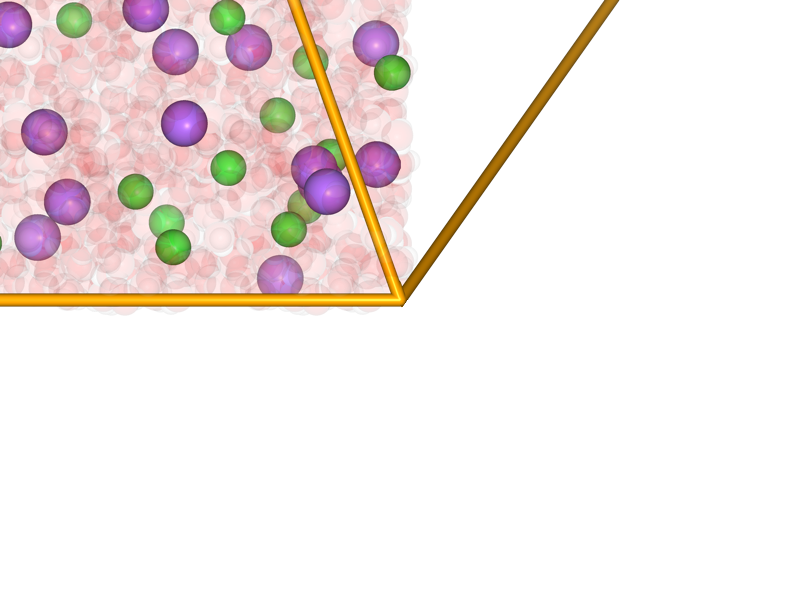

In [16]:
a._remote_call('setSize',target='Widget',args=['800px','600px'])
a.render_image(frame=0,factor=1)
a._display_image()

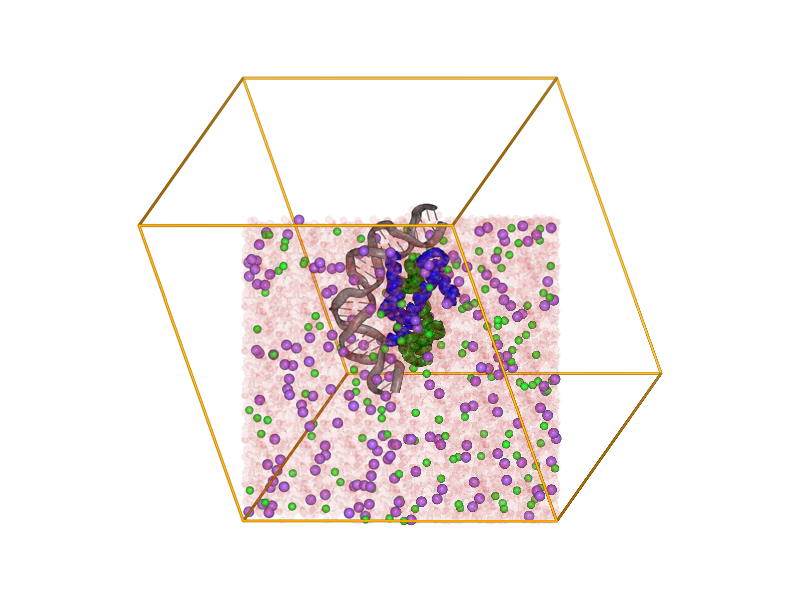

In [17]:
a._remote_call('setSize',target='Widget',args=['800px','600px'])
a.render_image(frame=0,factor=1)
a._display_image()

In [18]:
import base64
data=str.encode(a._image_data)
with open("results/system_image.png", "wb") as fh:
    fh.write(base64.decodebytes(data))